# PyTorch Layer 이해하기

# 예제 불러오기

In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=1)

In [4]:
image, label = next(iter(train_loader))

In [5]:
image.shape, label.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

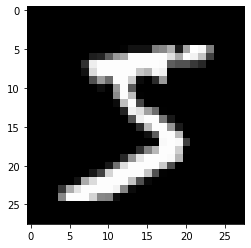

In [6]:
plt.imshow(image[0,0,:,:],'gray')
plt.show()

# 각 Layer별 설명

- Network 쌓기 위한 준비

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Convolution

- in_channels: 받게 될 channel의 갯수
- out_channels: 보내고 싶은 channel의 갯수  
- kernel_size: 만들고 싶은 kernel(weights)의 사이즈

- 채널을 지정해줘야 된다 채널 몇개를 받는지 적어야한다

In [8]:
nn.Conv2d(in_channels = 1, out_channels = 20, kernel_size = 5, stride = 1)

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [9]:
layer = nn.Conv2d(1, 20, 5, 1).to(torch.device('cpu'))
layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

- weight 시각화를 위해 slice하고 numpy화

In [10]:
weight = layer.weight
weight.shape

torch.Size([20, 1, 5, 5])

- 여기서 weight는 학습 가능한 상태이기 때문에 바로 numpy로 뽑아낼 수 없음
- detach() method는 그래프에서 잠깐 빼서 gradient에 영향을 받지 않게 함

In [11]:
weight = weight.detach().numpy()

In [12]:
weight.shape

(20, 1, 5, 5)

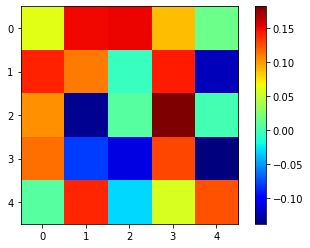

In [13]:
plt.imshow(weight[0,0,:,:],'jet')
plt.colorbar()
plt.show()

- output 시각화 준비를 위해 numpy화

In [14]:
output_data = layer(image)

In [15]:
output_data = output_data.data

In [16]:
output = output_data.cpu().numpy()

In [17]:
output.shape

(1, 20, 24, 24)

- Input으로 들어간 이미지 numpy화 

In [18]:
image_arr = image.numpy()
image_arr.shape

(1, 1, 28, 28)

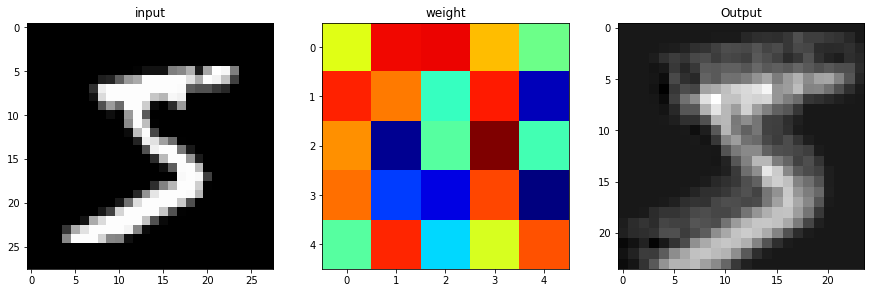

In [19]:
plt.figure(figsize=(15,30))
plt.subplot(131)
plt.title("input")
plt.imshow(np.squeeze(image_arr),'gray')

plt.subplot(132)
plt.title("weight")
plt.imshow(weight[0,0,:,:],'jet')

plt.subplot(133)
plt.title("Output")
plt.imshow(output[0,0,:,:],'gray')
plt.show()

### Pooling

input을 먼저 앞에 넣고, 뒤에 kernel 사이즈와 stride를 순서대로 넣음

In [20]:
image.shape

torch.Size([1, 1, 28, 28])

In [21]:
pool = F.max_pool2d(image,2,2)
pool.shape

torch.Size([1, 1, 14, 14])

- MaxPool Layer는 weight가 없기 때문에 바로 numpy()가 가능

In [22]:
pool_arr = pool.numpy()
pool_arr.shape

(1, 1, 14, 14)

In [23]:
image_arr.shape

(1, 1, 28, 28)

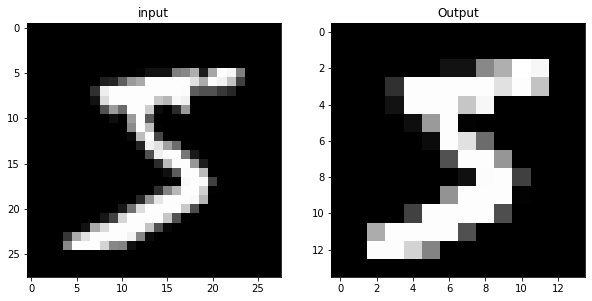

In [24]:
plt.figure(figsize=(10,15))
plt.subplot(121)
plt.title("input")
plt.imshow(np.squeeze(image_arr),'gray')

plt.subplot(122)
plt.title("Output")
plt.imshow(np.squeeze(pool_arr),'gray')
plt.show()

### Linear

- nn.Linear는 2d가 아닌 1d만 들어가기 때문에 .view() 1D로 펼쳐줘야함
- PyTorch는 Flatten이 없기 때문에 reshape나 view로 해줘야한다

In [25]:
image.shape

torch.Size([1, 1, 28, 28])

In [26]:
flatten = image.view(1,28 * 28)
flatten.shape

torch.Size([1, 784])

In [27]:
lin = nn.Linear(784, 10)(flatten) # 784개를 받아서 10개로 내보낸다
lin.shape

torch.Size([1, 10])

In [28]:
lin

tensor([[-0.0223,  0.1301, -0.0804,  0.0431,  0.1217, -0.2124,  0.0841,  0.3759,
          0.0772, -0.0162]], grad_fn=<AddmmBackward>)

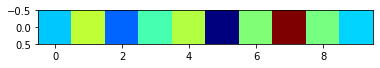

In [30]:
plt.imshow(lin.detach().numpy(),'jet')
plt.show()

### Softmax

결과를 numpy로 꺼내기 위해선 weight가 담긴 Linear에 weight를 꺼줘야함

In [31]:
with torch.no_grad(): # no_grad를 안하면 softmax를 볼 수 없다
    flatten = image.view(1, 28 * 28)
    lin = nn.Linear(784, 10)(flatten)
    softmax = F.softmax(lin, dim=1)

In [32]:
softmax

tensor([[0.0784, 0.0950, 0.1223, 0.0711, 0.1356, 0.1245, 0.0974, 0.0880, 0.0919,
         0.0960]])

In [33]:
np.sum(softmax.numpy())

1.0000001

# Layer 쌓기

예제 출처: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#id23

nn 과 nn.functional의 차이점
- nn은 학습 파라미터가 담긴 것 
- nn.functional은 학습 파라미터가 없는 것이라 생각하면 간단

In [39]:
class Net(nn.Module):
    def __init__(self): # 학습이 가능한 레이어
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,20,5,1)
        self.conv2 = nn.Conv2d(20,50,5,1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500,10)
        
    def forward(self, x):
        # Feature Extraction
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        print(x.shape)

- Image를 Model에 넣어서 결과 확인

In [40]:
model = Net()

- 위에 4 * 4 * 50을 알아내는 방법이다

In [41]:
result = model.forward(image)

torch.Size([1, 50, 4, 4])


In [42]:
class Net(nn.Module):
    def __init__(self): # 학습이 가능한 레이어
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,20,5,1)
        self.conv2 = nn.Conv2d(20,50,5,1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500,10)
        
    def forward(self, x):
        # Feature Extraction
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # Fully Connected (Classfication)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [43]:
model = Net()

In [44]:
result = model.forward(image)

In [45]:
result

tensor([[-2.2648, -2.2618, -2.3346, -2.3047, -2.3427, -2.2448, -2.3072, -2.3652,
         -2.3804, -2.2317]], grad_fn=<LogSoftmaxBackward>)

- 위에 설정한 것을 하나씩 확인해 볼 수 있다

In [46]:
model.conv1

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))